In [1]:
import os
import numpy as np
from PyMieSim.Tools.Mesh        import FibonacciMesh
from scipy.interpolate import RectSphereBivariateSpline, interp1d, interp2d, griddata
from PyMieSim.Tools.utils import RotateComplex
from PyMieSim.Tools.Directories import LPModePath
import matplotlib.pyplot as plt
from pathlib import Path


def LoadStructuredLPMode(mode):
    filename = f'LP{mode[0]}{mode[1]}/Structured.npy'

    fileDir = os.path.join(LPModePath, filename)

    if not os.path.exists(fileDir):
        raise ValueError( f'Could not load file: {fileDir}' )

    return np.load(fileDir)

def Sp2Cart(Phi, Theta, R=None):
    if R is None: R = Phi*0+1
    x = R*np.cos(Phi)*np.cos(Theta)
    y = R*np.cos(Phi)*np.sin(Theta)
    z = R*np.sin(Phi)
    return x,y,z


def GetSphericalMesh(Sampling, MaxAngle):
    Rmax = 100
    x, y = np.mgrid[-Rmax: Rmax: complex(Sampling), -Rmax: Rmax: complex(Sampling)]
    z = x*0 + Rmax / np.tan(MaxAngle)
    _, theta, phi = Cart2Sp(x, y, z)

    return phi, theta

def Cart2Sp(x,y,z):
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arcsin(z/r)
    phi = np.arctan2(y, x)
    return r, phi, theta


def GetUnstructuredField(Mode, Sampling, Rotation=0, Structured=False):
    modeField = LoadStructuredLPMode(Mode)

    if Rotation !=0: modeField = RotateComplex(modeField, Rotation)

    if Structured: return modeField

    Phi, Theta = GetSphericalMesh(Sampling=modeField.shape[0], MaxAngle=0.5)

    mesh = FibonacciMesh(MaxAngle    = 0.5,
                         Sampling    = Sampling,
                         PhiOffset   = 0,
                         GammaOffset = 0)

    InterpReal = Interpolator2D(values         = modeField.ravel().real,
                                lats           = Phi.ravel(),
                                lons           = Theta.ravel(),
                                origin         = (0,0),
                                method_irreg   = 'regularize')

    InterpImag = Interpolator2D(values         = modeField.ravel().imag,
                                lats           = Phi.ravel(),
                                lons           = Theta.ravel(),
                                origin         = (0,0),
                                method_irreg   = 'regularize')

    dataReal = InterpReal.interp(lat             = mesh.Phi.Radian,
                                 lon             = mesh.Theta.Radian,
                                 grid            = False,
                                 squeeze         = True,
                                 lat_deriv_order = 0,
                                 lon_deriv_order = 0)

    dataImag = InterpImag.interp(lat             = mesh.Phi.Radian,
                                 lon             = mesh.Theta.Radian,
                                 grid            = False,
                                 squeeze         = True,
                                 lat_deriv_order = 0,
                                 lon_deriv_order = 0)

    data = dataReal + 1j * dataImag

    norm = np.sqrt(np.sum(np.abs(data)**2))

    return data/norm

def GetFarFieldLP(Mode, MaxAngle, Sampling, Rotation=0, Structured=False):
    modeField = LoadLPMode(Mode)

    if Rotation !=0: modeField = RotateComplex(modeField, Rotation)

    if Structured: return modeField

    Phi, Theta = GetSphericalMesh(Sampling=modeField.shape[0], MaxAngle=MaxAngle)

    mesh = FibonacciMesh(MaxAngle    = MaxAngle,
                         Sampling    = Sampling,
                         PhiOffset   = 0,
                         GammaOffset = 0)

    InterpReal = Interpolator2D(values         = modeField.ravel().real,
                                lats           = Phi.ravel(),
                                lons           = Theta.ravel(),
                                origin         = (0,0),
                                method_irreg   = 'regularize')

    InterpImag = Interpolator2D(values         = modeField.ravel().imag,
                                lats           = Phi.ravel(),
                                lons           = Theta.ravel(),
                                origin         = (0,0),
                                method_irreg   = 'regularize')

    dataReal = InterpReal.interp(lat             = mesh.Phi.Radian,
                                 lon             = mesh.Theta.Radian,
                                 grid            = False,
                                 squeeze         = True,
                                 lat_deriv_order = 0,
                                 lon_deriv_order = 0)

    dataImag = InterpImag.interp(lat             = mesh.Phi.Radian,
                                 lon             = mesh.Theta.Radian,
                                 grid            = False,
                                 squeeze         = True,
                                 lat_deriv_order = 0,
                                 lon_deriv_order = 0)

    data = dataReal + 1j * dataImag

    norm = np.sqrt(np.sum(np.abs(data)**2))

    return data/norm



class Interpolator2D():
    """ Class for interpolating 2D (lat,lon) geospatial data.

        For irregular grids, the data values must be passed as a
        1d array and all three arrays (values, lats, lons) must have
        the same length.

        For regular grids, the data values must be passed as a
        2d array with shape (M,N) where M and N are the lengths
        of the latitude and longitude array, respectively.

        Attributes:
            values: 1d or 2d numpy array
                Values to be interpolated
            lats: 1d numpy array
                Latitude values
            lons: 1d numpy array
                Longitude values
            origin: tuple(float,float)
                Reference location (origo of XY coordinate system).
            method_irreg : {‘linear’, ‘nearest’, ‘cubic’, ‘regularize’}, optional
                Interpolation method used for irregular grids.
                Note that 'nearest' is usually significantly faster than
                the 'linear' and 'cubic'.
                If the 'regularize' is selected, the data is first mapped onto
                a regular grid by means of a linear interpolation (for points outside
                the area covered by the data, a nearest-point interpolation is used).
                The bin size of the regular grid is specified via the reg_bin argument.
            bins_irreg_max: int
                Maximum number of bins along either axis of the regular grid onto which
                the irregular data is mapped. Only relevant if method_irreg is set to
                'regularize'. Default is 2000.
    """
    def __init__(self, values, lats, lons, origin=None, method_irreg='regularize', bins_irreg_max=400):

        # compute coordinates of origin, if not provided
        if origin is None: origin = center_point(lats, lons)
        self.origin = origin

        # check if bathymetry data are on a regular or irregular grid
        reggrid = (np.ndim(values) == 2)

        # convert to radians
        lats_rad, lons_rad = torad(lats, lons)

        # necessary to resolve a mismatch between scipy and underlying Fortran code
        # https://github.com/scipy/scipy/issues/6556
        if np.min(lons_rad) < 0: self._lon_corr = np.pi
        else: self._lon_corr = 0
        lons_rad += self._lon_corr

        # initialize lat-lon interpolator
        if reggrid: # regular grid
            if len(lats) > 2 and len(lons) > 2:
                self.interp_ll = RectSphereBivariateSpline(u=lats_rad, v=lons_rad, r=values)
            elif len(lats) > 1 and len(lons) > 1:
                z = np.swapaxes(values, 0, 1)
                self.interp_ll = interp2d(x=lats_rad, y=lons_rad, z=z, kind='linear')
            elif len(lats) == 1:
                self.interp_ll = interp1d(x=lons_rad, y=np.squeeze(values), kind='linear')
            elif len(lons) == 1:
                self.interp_ll = interp1d(x=lats_rad, y=np.squeeze(values), kind='linear')

        else: # irregular grid
            if len(np.unique(lats)) <= 1 or len(np.unique(lons)) <= 1:
                self.interp_ll = GridData2D(u=lats_rad, v=lons_rad, r=values, method='nearest')

            elif method_irreg == 'regularize':

                # initialize interpolators on irregular grid
                if len(np.unique(lats)) >= 2 and len(np.unique(lons)) >= 2: method='linear'
                else: method = 'nearest'
                gd = GridData2D(u=lats_rad, v=lons_rad, r=values, method=method)
                gd_near = GridData2D(u=lats_rad, v=lons_rad, r=values, method='nearest')

                # determine bin size for regular grid
                lat_diffs = np.diff(np.sort(np.unique(lats)))
                lat_diffs = lat_diffs[lat_diffs > 1e-4]
                lon_diffs = np.diff(np.sort(np.unique(lons)))
                lon_diffs = lon_diffs[lon_diffs > 1e-4]
                bin_size = (np.min(lat_diffs), np.min(lon_diffs))

                # regular grid that data will be mapped to
                lats_reg, lons_reg = self._create_grid(lats=lats, lons=lons, bin_size=bin_size, max_bins=bins_irreg_max)

                # map to regular grid
                lats_reg_rad, lons_reg_rad = torad(lats_reg, lons_reg)
                lons_reg_rad += self._lon_corr
                vi = gd(theta=lats_reg_rad, phi=lons_reg_rad, grid=True)
                vi_near = gd_near(theta=lats_reg_rad, phi=lons_reg_rad, grid=True)
                indices_nan = np.where(np.isnan(vi))
                vi[indices_nan] = vi_near[indices_nan]

                # initialize interpolator on regular grid
                self.interp_ll = RectSphereBivariateSpline(u=lats_reg_rad, v=lons_reg_rad, r=vi)

            else:
                self.interp_ll = GridData2D(u=lats_rad, v=lons_rad, r=values, method=method_irreg)

        # store data used for interpolation
        self.lat_nodes = lats
        self.lon_nodes = lons
        self.values = values



    def interp(self, lat, lon, grid=False, squeeze=True, lat_deriv_order=0, lon_deriv_order=0):
        """ Interpolate using spherical coordinate system (latitude-longitude).

            lat and lot can be floats or arrays.

            If grid is set to False, the interpolation will be evaluated at
            the coordinates (lat_i, lon_i), where lat=(lat_1,...,lat_N)
            and lon=(lon_1,...,lon_N). Note that in this case, lat and
            lon must have the same length.

            If grid is set to True, the interpolation will be evaluated at
            all combinations (lat_i, lon_j), where lat=(lat_1,...,lat_N)
            and lon=(lon_1,...,lon_M). Note that in this case, the lengths
            of lat and lon do not have to be the same.

            Derivates are given per radians^n, where n is the overall
            derivative order.

            Args:
                lat: float or array
                    latitude of the positions(s) where the interpolation is to be evaluated
                lon: float or array
                    longitude of the positions(s) where the interpolation is to be evaluated
                grid: bool
                    Specify how to combine elements of lat and lon. If lat and lon have different
                    lengths, specifying grid has no effect as it is automatically set to True.
                lat_deriv_order: int
                    Order of latitude-derivative
                lon_deriv_order: int
                    Order of longitude-derivative

            Returns:
                zi: Interpolated values (or derivates)
        """
        lat = np.squeeze(np.array(lat))
        lon = np.squeeze(np.array(lon))
        lat_rad, lon_rad = torad(lat, lon)
        lon_rad += self._lon_corr

        if isinstance(self.interp_ll, interp2d):
            zi = self.interp_ll.__call__(x=lat_rad, y=lon_rad, dx=lat_deriv_order, dy=lon_deriv_order)
            if grid: zi = np.swapaxes(zi, 0, 1)
            if not grid and np.ndim(zi) == 2: zi = np.diagonal(zi)

        elif isinstance(self.interp_ll, interp1d):
            if len(self.lat_nodes) > 1:
                zi = self.interp_ll(x=lat_rad)
            elif len(self.lon_nodes) > 1:
                zi = self.interp_ll(x=lon_rad)

        else:
            zi = self.interp_ll.__call__(theta=lat_rad, phi=lon_rad, grid=grid, dtheta=lat_deriv_order, dphi=lon_deriv_order)

        if squeeze:
            zi = np.squeeze(zi)

        if np.ndim(zi) == 0 or (np.ndim(zi) == 1 and len(zi) == 1):
            zi = float(zi)

        return zi


    def _create_grid(self, lats, lons, bin_size, max_bins):
        """ Created regular lat-lon grid with uniform spacing that covers
            a set of (lat,lon) coordinates.

            Args:
                lats: numpy.array
                    Latitude values in degrees
                lons: numpy.array
                    Longitude values in degrees
                bin_size: float or tuple(float,float)
                    Lat and long bin size
                max_bins: int
                    Maximum number of bins along either axis

            Returns:
                : numpy.array, numpy.array
                    Latitude and longitude values of the regular grid
        """
        if isinstance(bin_size, (int,float)): bin_size = (bin_size, bin_size)
        res = []
        for v,dv in zip([lats,lons], bin_size):
            v_min = np.min(v) - dv
            v_max = np.max(v) + dv
            num = max(3, int((v_max - v_min) / dv) + 1)
            num = min(max_bins, num)
            v_reg = np.linspace(v_min, v_max, num=num)
            res.append(v_reg)

        return tuple(res)

def center_point(lat, lon):
    """ centerpoint of lat/lon bounds """
    if isinstance(lat, (list, tuple, np.ndarray)):
        return (np.min(lat) + np.max(lat)) / 2, (np.min(lon) + np.max(lon)) / 2

    return lat, lon

def torad(lat, lon):
    """ Convert latitute and longitude values from degrees to radians.

        The method expects the latitude to be in the range (-90,90) and
        the longitude to be in the range (-180,180).

        The output latitude is in the range (0,pi) and the output
        longitude is in the range (-pi,pi).

        Args:
            lat: float or array
                latitude(s) in degrees from -90 to +90.
            lon: float or array
                longitude(s) in degrees from -180 to +180.

        Returns:
            lat_rad: float or array
                latitude(s) in radians from 0 to pi.
            lon_rad: float or array
                longitude(s) in radians from -pi to pi.
    """
    lat_rad = (lat + 90) * (np.pi/180)
    lon_rad = lon * (np.pi/180)
    return lat_rad, lon_rad


class GridData2D():
    """ Interpolation of data on a two-dimensional irregular grid.

        Essentially, a wrapper function around scipy's interpolate.griddata.

        https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.interpolate.griddata.html

        An alternative to griddata could be Rbf, as discussed here:

        https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy

        Attributes:
            u: 1d numpy array
                data points 1st coordinate
            v: 1d numpy array
                data points 2nd coordinate
            r: 1d numpy array
                data values
            method : {‘linear’, ‘nearest’, ‘cubic’}, optional

    """

    def __init__(self, u, v, r, method='linear'):
        self.uv = np.array([u,v]).T
        self.r = r
        self.method = method


    def __call__(self, theta, phi, grid=False, dtheta=0, dphi=0):
        """ Interpolate data

            theta and phi can be floats or arrays.

            If grid is set to False, the interpolation will be evaluated at
            the positions (theta_i, phi_i), where theta=(theta_1,...,theta_N) and
            phi=(phi_1,...,phi_N). Note that in this case, theta and phi must have
            the same length.

            If grid is set to True, the interpolation will be evaluated at
            all combinations (theta_i, phi_j), where theta=(theta_1,...,theta_N) and
            phi=(phi_1,...,phi_M). Note that in this case, the lengths of theta
            and phi do not have to be the same.

            Note: Interpolation of derivates not yet implemented; dtheta > 0 or dphi > 0
            will result in AssertionError.

            Args:
                theta: float or array
                   1st coordinate of the points where the interpolation is to be evaluated
                phi: float or array
                   2nd coordinate of the points where the interpolation is to be evaluated
                grid: bool
                   Specify how to combine elements of theta and phi.
                dtheta: int
                    Order of theta-derivative
                dphi: int
                    Order of phi-derivative

            Returns:
                ri: Interpolated values
        """
        assert dtheta + dphi == 0, "Interpolation of derivatives not implemented for irregular grids"

        if grid: theta, phi, M, N = self._meshgrid(theta, phi)

        pts = np.array([theta,phi]).T
        ri = griddata(self.uv, self.r, pts, method=self.method)


        if grid:
            ri = np.reshape(ri, newshape=(N,M))
            ri = np.swapaxes(ri, 0, 1)

        return ri

    def _meshgrid(self, theta, phi):
        """ Create grid

            Args:
                theta: 1d numpy array
                   1st coordinate of the points where the interpolation is to be evaluated
                phi: 1d numpy array
                   2nd coordinate of the points where the interpolation is to be evaluated

            Returns:
                theta, phi: 2d numpy array
                    Grid coordinates
                M, N: int
                    Number of grid values
        """
        M = 1
        N = 1
        if np.ndim(theta) == 1: M = len(theta)
        if np.ndim(phi) == 1: N = len(phi)
        theta, phi = np.meshgrid(theta, phi)
        theta = theta.flatten()
        phi = phi.flatten()
        return theta, phi, M, N

    
def LoadUnstructuredLPMode(mode, Sampling=100):
    filename = f'LP{mode[0]}{mode[1]}/Unstructured{Sampling}.npy'

    fileDir = os.path.join(LPModePath, filename)

    if not os.path.exists(fileDir):
        raise ValueError( f"File: {fileDir} does not exists. This specific LP mode with specific sampling might not be available" )

    return np.load(fileDir)




In [8]:
def CreateStructuredLPMode(Modes):
    import matplotlib.pyplot as plt
    import fibermodes
    from fibermodes import FiberFactory, Mode, ModeFamily, Wavelength, PSimulator

    for mode in Modes:
        print(f'Generating structured mode LP {mode}')
        
        fileDir = os.path.join(LPModePath, f'LP{mode[0]}{mode[1]}')
        
        if not os.path.exists(fileDir):
            os.makedirs(fileDir)
        
        filename = os.path.join(fileDir, "Structured.npy")
        
        factory = FiberFactory() 

        he11 = Mode(ModeFamily.LP, mode[0]+1, mode[1])

        factory.addLayer(pos=0, name="clad", geometry="StepIndex", index=1.4444, radius=62.5)

        factory.addLayer(pos=0, name="core", geometry="StepIndex", radius=20e-6, index=1.474)

        fiber = factory[0]

        sim = PSimulator(factory, [1550e-9], vectorial=False, scalar=True, numax=6, mmax=2)

        field = fibermodes.field.Field(fiber, mode=he11, wl=Wavelength(1550e-9), r=25e-6, np=500)
        
        np.save(file = filename, arr = field.Ex())

        
def CreateUnStructuredLPMode(Modes):
    for Mode in Modes:
        for Sampling in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
            print(f'Generating unstructured modes: LP{Mode[0]}{Mode[1]} | Sampling: {Sampling}')
            Field = GetUnstructuredField(Mode, Sampling, Rotation=0)

            mesh = FibonacciMesh(MaxAngle    = 0.3,
                                 Sampling    = Sampling,
                                 PhiOffset   = 0,
                                 GammaOffset = 0)


            x, y, z = Sp2Cart(mesh.Phi.Radian, mesh.Theta.Radian)
            
            np.save(f'./LP{Mode[0]}{Mode[1]}/Unstructured{Sampling}', Field)

In [9]:
Modes = [(0,1), (0,2), (0,3), (0,4), (1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3), (2,4), (3,1), (3,2), (3,3), (3,4), (4,1), (4,2), (4,3), (5,1), (5,2)]

In [10]:
CreateStructuredLPMode(Modes = Modes )

CreateUnStructuredLPMode(Modes = Modes )

Generating structured mode LP (0, 1)
Generating structured mode LP (0, 2)
Generating structured mode LP (0, 3)
Generating structured mode LP (0, 4)
Generating structured mode LP (1, 1)
Generating structured mode LP (1, 2)
Generating structured mode LP (1, 3)
Generating structured mode LP (1, 4)
Generating structured mode LP (2, 1)
Generating structured mode LP (2, 2)
Generating structured mode LP (2, 3)
Generating structured mode LP (2, 4)
Generating structured mode LP (3, 1)
Generating structured mode LP (3, 2)
Generating structured mode LP (3, 3)
Generating structured mode LP (3, 4)
Generating structured mode LP (4, 1)
Generating structured mode LP (4, 2)
Generating structured mode LP (4, 3)
Generating structured mode LP (5, 1)
Generating structured mode LP (5, 2)
Generating unstructured modes: LP01 | Sampling: 100
Generating unstructured modes: LP01 | Sampling: 200
Generating unstructured modes: LP01 | Sampling: 300
Generating unstructured modes: LP01 | Sampling: 400
Generating unst

Generating unstructured modes: LP33 | Sampling: 400
Generating unstructured modes: LP33 | Sampling: 500
Generating unstructured modes: LP33 | Sampling: 600
Generating unstructured modes: LP33 | Sampling: 700
Generating unstructured modes: LP33 | Sampling: 800
Generating unstructured modes: LP33 | Sampling: 900
Generating unstructured modes: LP33 | Sampling: 1000
Generating unstructured modes: LP34 | Sampling: 100
Generating unstructured modes: LP34 | Sampling: 200
Generating unstructured modes: LP34 | Sampling: 300
Generating unstructured modes: LP34 | Sampling: 400
Generating unstructured modes: LP34 | Sampling: 500
Generating unstructured modes: LP34 | Sampling: 600
Generating unstructured modes: LP34 | Sampling: 700
Generating unstructured modes: LP34 | Sampling: 800
Generating unstructured modes: LP34 | Sampling: 900
Generating unstructured modes: LP34 | Sampling: 1000
Generating unstructured modes: LP41 | Sampling: 100
Generating unstructured modes: LP41 | Sampling: 200
Generating

/var/folders/z9/7t92p3213fb2p8qsqv_4lnx00000gn/T/ipykernel_96345/2407825008.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(field)


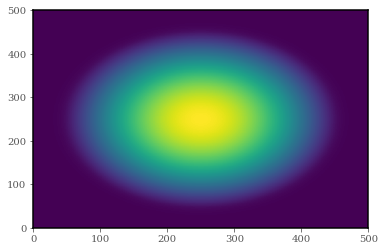

In [15]:
plt.figure()

field = np.load(os.path.join(LPModePath, 'LP01/Structured.npy'))

plt.pcolormesh(field)

plt.show()